# This notebook is meant to train a Neural Network model using keras for a Self Driving Vehicle Speed Synchronization

### Parameters
- Optimizer - Stochastic Gradient Descent
- Loss function - Mean Squared Error
- Input layer - 2 values
- Output layer - 3 categories (Stay, Left or Right)
- Hidden layer - 1 layer with 5 nodes
- Epochs - 100
- Batch size - 10

In [758]:
import random

import keras
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
# Importing necessary libraries
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Activation, Dense

In [759]:
# Reading out data
df = pd.read_csv('../data/Waqar.csv')
df.head()

,Unnamed: 0,0,1,2
0,0,1,0,0
1,1,1,0,0
2,2,1,0,0
3,3,1,0,0
4,4,1,0,0


In [760]:
# Removing redundant column Unnamed: 0
df = df.drop('Unnamed: 0', 1)

### From the table above we see that the column ```Unnamed: 0``` is redundant, as it shows the count of rows which can be found in pandas table whenever printing a dataframe.

### The headers of columns are meaningless. They should be renamed to the following:
- First column - Is Behind,
- Second column - Is Side By Side,
- Third column - Action

In [761]:
# Renaming headers of columns
df.rename(columns={'0': 'Is Behind', '1': 'Is Side By Side', '2': 'Action'}, inplace=True)
df.head()

,Is Behind,Is Side By Side,Action
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


### ```Action``` have integer values from 0 to 2
### ```Is Side By Side``` & ```Is Behind``` have integer values from 0 to 1

In [762]:
# Checking data insights
df.describe()

,Is Behind,Is Side By Side,Action
count,147.000000,147.000000,147.000000
mean,0.061224,0.748299,1.129252
std,0.240561,0.435474,0.486420
min,0.000000,0.000000,0.000000
25%,0.000000,0.500000,1.000000
50%,0.000000,1.000000,1.000000
75%,0.000000,1.000000,1.000000
max,1.000000,1.000000,2.000000


### From the table above we can assume the following:
### ```Mean``` values of all columns are acceptable
- For <b>My_position</b> and <b>Action</b> columns the mean is expected to be around 1
- For <b>Left_line</b>, <b>Mid_line</b>, <b>Right_line</b> columns the mean is expected to be around 3.5

### ```Std``` values of all columns are acceptable, although ```Action``` column seems a bit off
- For <b>My_position</b> and <b>Action</b> columns the std is expected to be around 1
- For <b>Left_line</b>, <b>Mid_line</b>, <b>Right_line</b> columns the std is expected to be around 2 - 3

### ```Min``` values of all columns are correct
- For <b>My_position</b> and <b>Action</b> columns the min has to be equal to 0
- For <b>Left_line</b>, <b>Mid_line</b>, <b>Right_line</b> columns the min has to be equal to 0

### ```Max``` values of all columns are correct
- For <b>My_position</b> and <b>Action</b> columns the max has to be equal to 2
- For <b>Left_line</b>, <b>Mid_line</b>, <b>Right_line</b> columns the max has to be equal to 7

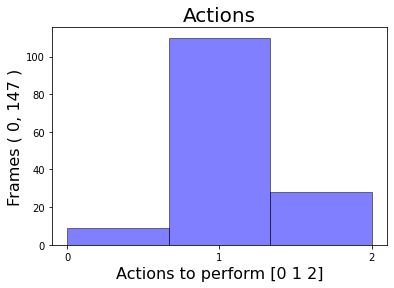

In [763]:
# Build up a histogram of Actions column to find out why std is small
# Action types are as follows: Left - 0, Stay - 1, Right -2
column = df['Action']
# Set a title for histogram
plt.title('Actions', fontsize=20)
# Find out amount of unique actions
unique_actions = len(column.unique())
# Set X axis to have only values of the actions that exist in the column
plt.xticks(column.unique())
# Show actions that can be performed on the X axis
plt.xlabel('Actions to perform ' + str(column.unique()), fontsize=16)
# Show total amount of values the column has
plt.ylabel('Frames ( 0, ' + str(len(df['Action'])) + ' )', fontsize=16)
# Set the histogram with above properties
plt.hist(column, unique_actions, facecolor='blue', ec='black', alpha=0.5)
# Show the histogram
plt.show()

### From the histogram above we can see that most of the actions are 1 which means stay
These makes sense, since every 2 frames a new car appears and when it does it have to choose only 1 road line to appear at. Every batch 6 of cells (3 lines in 2 steps) had only 1 car on it, which let my car stand most of the time

In [764]:
# See amount of unique values of Action column
df['Action'].value_counts()

1    110
2     28
0      9
Name: Action, dtype: int64

### If we train our model with this data, it will assume that standing is the best choice in most of the cases. There are several ways to solve this problem. Some of them are listed below:
- We need to train some more data saved in another file and add from that to this file new rows with actions other than 1 to this dataset
- Remove some results from this dataframe where action is 1


#### We will take the last choice and remove some portion of data that has action 1
#### Find out the portion to be removed from ~16k down to ~2k. It makes 12.5%
#### We will take random number between 0 and 125 and if it is greater than 13 we will remove the Action

In [765]:
# Set 87.5% of the actions that has value 1 to NaN, so that later they can be removed from db
for i in range(len(df['Action'])):
    if df['Action'][i] == 1:
        a = random.randint(0, 100)
        if a > 40:
            df['Action'][i] = None

c:\users\mwaqa\anaconda3\envs\racingai\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [766]:
# Remove the rows that have NaN as a result of Action column
df = df.dropna()

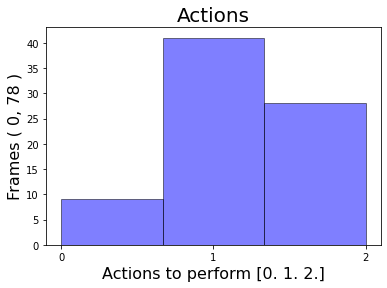

In [767]:
# Build up a histogram of Actions column to find out why std is small
# Action types are as follows: Left - 0, Stay - 1, Right -2
column = df['Action']
# Set a title for histogram
plt.title('Actions', fontsize=20)
# Find out amount of unique actions
unique_actions = len(column.unique())
# Set X axis to have only values of the actions that exist in the column
plt.xticks(column.unique())
# Show actions that can be performed on the X axis
plt.xlabel('Actions to perform ' + str(column.unique()), fontsize=16)
# Show total amount of values the column has
plt.ylabel('Frames ( 0, ' + str(len(df['Action'])) + ' )', fontsize=16)
# Set the histogram with above properties
plt.hist(column, unique_actions, facecolor='blue', ec='black', alpha=0.5)
# Show the histogram
plt.show()

In [768]:
# Check the unique value counts in the Action column
df['Action'].value_counts()

1.0    41
2.0    28
0.0     9
Name: Action, dtype: int64

### After reducing Action column with specific value 1 by 87.5% we have normalized our dataset. This sort of action will lead to a better performance during training the model
### Now it is time to separate input data and labels and split it into train and test datasets

In [769]:
# Remove Action column and assign the rest to the new variable of input data
input_data = df.drop('Action', 1)
input_data.head()

,Is Behind,Is Side By Side
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


In [770]:
# Take only Action column to represent labels for the prediction
output_data = df['Action']

In [771]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.20, random_state=7)

In [772]:
# Prepare train and test labels into categorical model by 1 hot encoding it
y_train = keras.utils.to_categorical(y_train, 3)
y_test = keras.utils.to_categorical(y_test, 3)

In [773]:
# Define the keras model
model = Sequential()
model.add(Dense(16, input_shape=(2, )))
model.add(Activation('relu'))
# model.add(Dense(16, input_shape=(16, )))
# model.add(Activation('relu'))
model.add(Dense(3, input_shape=(16, )))
model.add(Activation('relu'))

In [774]:
# Compile the defined model
model.compile(
            optimizer='SGD',
            loss='mean_squared_error',
            metrics=['accuracy'])

In [775]:
# Train the keras model with the train dataset
model.fit(X_train, y_train, epochs=10, batch_size=14)

Epoch 1/10
5/5 [==============================] - 0s 750us/step - loss: 0.3514 - accuracy: 0.1120
Epoch 2/10
5/5 [==============================] - 0s 500us/step - loss: 0.3240 - accuracy: 0.1408
Epoch 3/10
5/5 [==============================] - 0s 500us/step - loss: 0.3048 - accuracy: 0.1259
Epoch 4/10
5/5 [==============================] - 0s 500us/step - loss: 0.2933 - accuracy: 0.0892
Epoch 5/10
5/5 [==============================] - 0s 500us/step - loss: 0.2707 - accuracy: 0.1339
Epoch 6/10
5/5 [==============================] - 0s 500us/step - loss: 0.2567 - accuracy: 0.1299

In [776]:
# Evaluate the keras model
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

1/1 [==============================] - 0s 56ms/step - loss: 0.2456 - accuracy: 0.5000
Accuracy: 50.00


In [777]:
# Create a HDF5 file to save the model
model.save('../models/categorical_crossentropy.h5')